In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

from pydrake.solvers import MathematicalProgram, Solve
import pydrake.symbolic as sym



In [2]:
import sympy as sp

In [3]:
t, p0x, p1x, p2x, p3x, p0y, p1y, p2y, p3y = sp.symbols('t p_{0x} p1x p2x p3x p0y p1y p2y p3y')
b3x = p0x*(1-t)**3 + p1x*3*(1-t)**2*t + p2x*3*(1-t)*t**2 + p3x*t**3
b3y = p0y*(1-t)**3 + p1y*3*(1-t)**2*t + p2y*3*(1-t)*t**2 + p3y*t**3

In [4]:
b3x.collect(p0x).collect(p1x).collect(p2x).collect(p3x)

3*p1x*t*(1 - t)**2 + 3*p2x*t**2*(1 - t) + p3x*t**3 + p_{0x}*(1 - t)**3

In [35]:
from pydrake.all import HPolyhedron
import numpy as np
from visualization_utils import plot_HPoly
import matplotlib.pyplot as plt

points = np.array([[0,-0.8],[-5,5]])
center_points = np.array([[0, 0],
                          [1.3, 1.4],
                          [2.2, 4.2],
                          [-1.6, 1],
                          [-3,3.7],
                          [-4.2, 5],
                          [0,6],
                          [0,3.7]])

sizes = np.array([[1,2],
                  [2,2],
                  [0.5,5.],
                  [3,1],
                  [1,5],
                  [2.2,2],
                  [6,0.3],
                  [0.8,5]])

regions =[]
for c, s in zip(center_points, sizes):
    l = c- s/2
    u = c + s/2
    regions.append(HPolyhedron.MakeBox(l,u))

safe_sets = []
safe_adjacencies = []

for id1, r1 in enumerate(regions):
    for id2, r2 in enumerate(regions):
        if id1 != id2:
            if r1.IntersectsWith(r2):
                safe_sets.append(r1.Intersection(r2))
                safe_adjacencies.append([id1, id2])

reppts = np.array([s.ChebyshevCenter() for s in safe_sets])

safe_ad = np.zeros((len(safe_sets), len(safe_sets)))
for id in range(len(regions)):
    idxs = np.where(np.array(safe_adjacencies)[:,0]==id)[0]
    for id1 in idxs:
        for id2 in idxs:
            if id1 != id2:
                safe_ad[id1, id2] =1

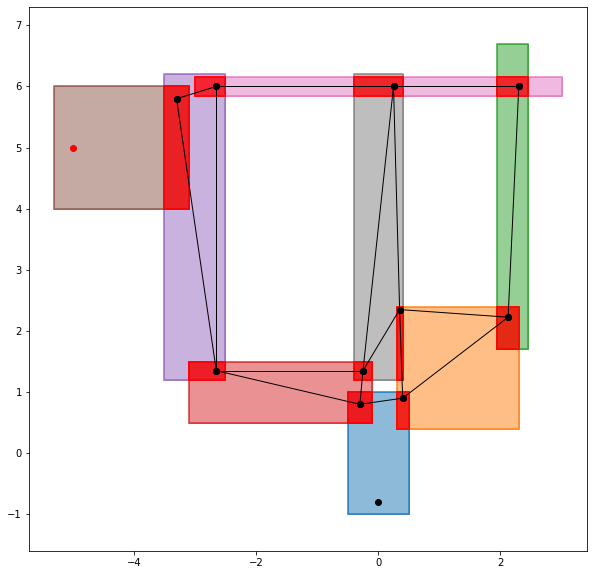

In [36]:
fig, ax = plt.subplots(figsize = (10,10))
for p,c in zip(points, ['k','r']):
    ax.scatter(p[0], p[1], c = c)
ax.axis('equal')
for r in regions:
    plot_HPoly(ax, r)
for r in safe_sets:
    plot_HPoly(ax, r, color = 'r')

for i in range(len(safe_sets)):
    for j in range(i+1, len(safe_sets)):
        if safe_ad[i,j]==1:
            x = [reppts[i][0], reppts[j][0]]
            y = [reppts[i][1], reppts[j][1]]
            ax.plot(x,y, linewidth = 1, c = 'k')
ax.scatter(reppts[:,0], reppts[:,1], c = 'k')

In [15]:
safe_adjacencies

[[0, 1],
 [0, 3],
 [1, 0],
 [1, 2],
 [2, 1],
 [2, 6],
 [3, 0],
 [3, 4],
 [4, 3],
 [4, 5],
 [4, 6],
 [5, 4],
 [6, 2],
 [6, 4]]

In [46]:
from dijkstraspp import DijkstraSPPsolver
def conv(q):
    return q
dspp = DijkstraSPPsolver(regions, conv)
wps, _ = dspp.solve(points[0], points[1], refine_path=True)
for i in range(len(wps)-1):
    ax.plot([wps[i][0], wps[i+1][0]], [wps[i][1], wps[i+1][1]], c = 'k', linewidth = 1)


array([ 0. , -0.8])

([array([ 0. , -0.8]),
  array([-0.3,  0.8]),
  array([-2.65,  1.35]),
  array([-3.45,  5.95]),
  array([-5.,  5.])],
 10.528398645080689)

In [40]:
b3diff= sp.diff(b3, t)
b3diffexp = sp.expand(b3diff)
b3diffexp.collect(p0).collect(p1).collect(p2).collect(p3)

p0*(-3*t**2 + 6*t - 3) + p1*(9*t**2 - 12*t + 3) + p2*(-9*t**2 + 6*t) + 3*p3*t**2

In [42]:
b3ddiff= sp.diff(b3diffexp, t)
b3ddiffexp = sp.expand(b3ddiff)
b3ddiffexp.collect(p0).collect(p1).collect(p2).collect(p3)

p0*(6 - 6*t) + p1*(18*t - 12) + p2*(6 - 18*t) + 6*p3*t

In [43]:
b3dddiff= sp.diff(b3ddiffexp, t)
b3dddiffexp = sp.expand(b3dddiff)
b3dddiffexp.collect(p0).collect(p1).collect(p2).collect(p3)

-6*p0 + 18*p1 - 18*p2 + 6*p3

In [12]:
def sort_terms_by_power(poly):
    # Get the terms of the polynomial
    terms = sp.Add.make_args(poly)
    
    # Sort the terms by their powers of 't'
    terms.sort(key=lambda term: sp.Poly(term, domain=sp.EX).as_dict().get(t, 0))

    # Create a new polynomial with the sorted terms
    sorted_poly = sp.Add(*terms)

    return sorted_poly

sort_terms_by_power(b3diffexp)

AttributeError: 'tuple' object has no attribute 'sort'

In [30]:
terms =list(sp.Add.make_args(b3diffexp))
sp.collect(b3, t)


p0*(1 - t)**3 + 3*p1*t*(1 - t)**2 + 3*p2*t**2*(1 - t) + p3*t**3

In [37]:
terms[3].has(t**3)


False


-9*p2*t**2

In [6]:
prog = MathematicalProgram()
# Declares indeterminates
t = prog.NewIndeterminates(1,'t')
p0 = prog.NewContinuousVariables(1, 'p0')
p1 = prog.NewContinuousVariables(1, 'p1')
p2 = prog.NewContinuousVariables(1, 'p2')
p3 = prog.NewContinuousVariables(1, 'p3')



In [7]:
exp = (1-t)**3*p0 + 3*(1-t)**2*t*p1 + 3*(1-t)*t**2*p2 + 3*t**2*p3 

array([<Expression "(3 * (t(0) * p1(0) * pow((1 - t(0)), 2)) + 3 * (pow(t(0), 2) * p2(0) * (1 - t(0))) + 3 * (pow(t(0), 2) * p3(0)) + (p0(0) * pow((1 - t(0)), 3)))">],
      dtype=object)